In [1]:
%load_ext Cython

In [2]:
import shutil
import os

import numpy as np
import scipy.sparse as sps

import porepy as pp
import pygeon as pg

from math import ceil, floor, log10, exp

/opt/conda/lib/python3.11/site-packages/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


For a manual import:

import sys
sys.path.append('/path/to/repository')

In [3]:
from utilities.assembly_utilities import local_A, local_Mh, transoform_nodal_func_to_physical_element
from richards.model_params import Model_Data
from richards.plot_exporter import Plot_Exporter
from richards.csv_exporter import Csv_Exporter

### Parameters

In [4]:
# Set the maximum number of iterations of the non-linear solver
K = 500

# L-scheme parameter
L = 3.501e-2 #0.1

# Set the mesh refinment
N = 40

# Set the number of steps (excluding the initial condition)
num_steps = 27

quad_order = 3

# Simulation time length
T = num_steps/48

# Time switch conditions (for the boundary condition)
dt_D = 3/48

# Fluid density
rho = 1000

# Relative and absolute tolerances for the non-linear solver
abs_tol = 1e-5
rel_tol = 1e-5

# Domain tolerance
domain_tolerance = 1 / (10 * N)

# Output directory
output_directory = 'lagrange_hard_coupling'

In [5]:
def initial_h(x): return 1

In [6]:
# Van Genuchten model parameters ( relative permeability model )
model_data = Model_Data(theta_r=0.131, theta_s=0.396, alpha=0.423, n=2.06, K_s=4.96e-2, T=T, num_steps=num_steps)

In [7]:
# Time step
dt   = (T-0)/num_steps

### Mesh

In [8]:
bottom_grid =   pp.StructuredTriangleGrid([2*N, N], [2, 1])
bottom_grid.compute_geometry()

In [9]:
top_grid    = pp.StructuredTriangleGrid([2*N, 2*N], [2, 2])
top_grid.compute_geometry()

In [10]:
boundary_grid, boundary_face_map, boundary_node_map  = pp.partition.extract_subgrid(bottom_grid, 
                                                                                    bottom_grid.face_centers[1, :] == 1, 
                                                                                    faces=True)

### Discretization fields

In [11]:
key = "flow"

In [12]:
top_field = pg.Lagrange1(key)
top_data = {}

top_dof =  top_field.ndof( top_grid )

In [13]:
bottom_field = pg.Lagrange1(key)
bottom_data = {}

bottom_dof = bottom_field.ndof( bottom_grid )

In [14]:
boundary_field = pg.Lagrange1(key)
boundary_data = {}

boundary_dof = boundary_field.ndof( boundary_grid )

### Restrictor Matrices

In [15]:
bottom_delete_boundary_dof = np.zeros( shape=(bottom_dof - boundary_dof, bottom_dof) )
bottom_delete_boundary_dof[np.arange(bottom_dof - boundary_dof), bottom_grid.nodes[1, :] < 1] = 1
bottom_delete_boundary_dof = sps.csr_matrix(bottom_delete_boundary_dof)

In [16]:
bottom_isolate_boundary_dof = np.zeros(shape=(boundary_dof, bottom_dof))
bottom_isolate_boundary_dof[np.arange(boundary_dof), bottom_grid.nodes[1, :] == 1] = 1
bottom_isolate_boundary_dof = sps.csr_matrix(bottom_isolate_boundary_dof)

In [17]:
top_delete_boundary_dof = np.zeros( shape=(top_dof - boundary_dof, top_dof) )
top_delete_boundary_dof[np.arange(top_dof - boundary_dof), top_grid.nodes[1, :] > 0] = 1
top_delete_boundary_dof = sps.csr_matrix(top_delete_boundary_dof)

In [18]:
top_isolate_boundary_dof = np.zeros(shape=(boundary_dof, top_dof))
top_isolate_boundary_dof[np.arange(boundary_dof), top_grid.nodes[1, :] == 0] = 1
top_isolate_boundary_dof = sps.csr_matrix(top_isolate_boundary_dof)

### BCs

In [19]:
bot_dirichlet_flag  = np.array(np.logical_and( bottom_grid.nodes[0, :] == 2, bottom_grid.nodes[1, :] <= 1 ), dtype=bool)
bot_dirichlet_value = np.array(bot_dirichlet_flag, dtype=float)

In [20]:
top_dirichlet_flag  = np.array(np.logical_and( top_grid.nodes[1, :] == 2, top_grid.nodes[0, :] <= 1 ), dtype=bool)
top_dirichlet_value = lambda t: np.array(top_dirichlet_flag, dtype=float) * min( 6.2, 1 + 5.2 * t / dt_D )

In [21]:
dirichlet_flag  = np.hstack(( bot_dirichlet_flag, top_dirichlet_flag, np.zeros(shape=boundary_dof, dtype=bool)))
dirichlet_value = lambda t: np.hstack(( bot_dirichlet_value, top_dirichlet_value(t), np.zeros(shape=boundary_dof, dtype=bool)))

### Matrix Assembly

##### Projection matrices

Matrices used to export the final solution to .vtu

In [22]:
top_proj    = top_field.eval_at_cell_centers( top_grid )
bottom_proj = bottom_field.eval_at_cell_centers( bottom_grid )

##### Stifness

In [23]:
def bottom_stifness_gen():
    size = np.power(bottom_grid.dim + 1, 2) * bottom_grid.num_cells
    rows_I = np.empty(size, dtype=int)
    cols_J = np.empty(size, dtype=int)
    data_IJ = np.empty(size)
    idx = 0

    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(bottom_grid)

    # Allocate the data to store matrix entries, that's the most efficient
    # way to create a sparse matrix.

    cell_nodes = bottom_grid.cell_nodes()

    for c in np.arange(bottom_grid.num_cells):
        # For the current cell retrieve its nodes
        loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

        nodes_loc = cell_nodes.indices[loc]
        coord_loc = node_coords[:, nodes_loc]

        # Compute the stiff-H1 local matrix

        A = local_A(coord_loc, lambda x,y: model_data.K_s * np.eye(2), quad_order)
        
        # Save values for stiff-H1 local matrix in the global structure
        cols = np.tile(nodes_loc, (nodes_loc.size, 1))

        loc_idx = slice(idx, idx + cols.size)
        rows_I[loc_idx] = cols.T.ravel()
        cols_J[loc_idx] = cols.ravel()
        data_IJ[loc_idx] = A.ravel()
        idx += cols.size

    # Construct the global matrices
    return sps.csc_matrix((data_IJ, (rows_I, cols_J)))

In [24]:
def top_stifness_gen(h_dofs):
    size = np.power(top_grid.dim + 1, 2) * top_grid.num_cells
    rows_I = np.empty(size, dtype=int)
    cols_J = np.empty(size, dtype=int)
    data_IJ = np.empty(size)
    idx = 0

    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(top_grid)

    # Allocate the data to store matrix entries, that's the most efficient
    # way to create a sparse matrix.

    cell_nodes = top_grid.cell_nodes()

    for c in np.arange(top_grid.num_cells):
        # For the current cell retrieve its nodes
        loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

        nodes_loc = cell_nodes.indices[loc]
        coord_loc = node_coords[:, nodes_loc]

        # Compute the stiff-H1 local matrix

        h_func = transoform_nodal_func_to_physical_element(h_dofs[nodes_loc], coord_loc)
        A = local_A(coord_loc, lambda x,y: model_data.hydraulic_conductivity_coefficient(h_func(x,y), 1+y) * np.eye(2), quad_order)
        
        # Save values for stiff-H1 local matrix in the global structure
        cols = np.tile(nodes_loc, (nodes_loc.size, 1))

        loc_idx = slice(idx, idx + cols.size)
        rows_I[loc_idx] = cols.T.ravel()
        cols_J[loc_idx] = cols.ravel()
        data_IJ[loc_idx] = A.ravel()
        idx += cols.size

    # Construct the global matrices
    return sps.csc_matrix((data_IJ, (rows_I, cols_J)))

##### Mass

In [25]:
def bottom_mass_gen():
    size = np.power(bottom_grid.dim + 1, 2) * bottom_grid.num_cells
    rows_I = np.empty(size, dtype=int)
    cols_J = np.empty(size, dtype=int)
    data_IJ = np.empty(size)
    idx = 0

    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(bottom_grid)

    # Allocate the data to store matrix entries, that's the most efficient
    # way to create a sparse matrix.

    cell_nodes = bottom_grid.cell_nodes()

    for c in np.arange(bottom_grid.num_cells):
        # For the current cell retrieve its nodes
        loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

        nodes_loc = cell_nodes.indices[loc]
        coord_loc = node_coords[:, nodes_loc]

        # Compute the stiff-H1 local matrix
        A = local_Mh(coord_loc, lambda x,y: 1, quad_order)

        # Save values for stiff-H1 local matrix in the global structure
        cols = np.tile(nodes_loc, (nodes_loc.size, 1))

        loc_idx = slice(idx, idx + cols.size)
        rows_I[loc_idx] = cols.T.ravel()
        cols_J[loc_idx] = cols.ravel()
        data_IJ[loc_idx] = A.ravel()
        idx += cols.size

    # Construct the global matrices
    return sps.csc_matrix((data_IJ, (rows_I, cols_J)))

In [26]:
def top_mass_gen():
    size = np.power(top_grid.dim + 1, 2) * top_grid.num_cells
    rows_I = np.empty(size, dtype=int)
    cols_J = np.empty(size, dtype=int)
    data_IJ = np.empty(size)
    idx = 0

    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(top_grid)

    # Allocate the data to store matrix entries, that's the most efficient
    # way to create a sparse matrix.

    cell_nodes = top_grid.cell_nodes()

    for c in np.arange(top_grid.num_cells):
        # For the current cell retrieve its nodes
        loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

        nodes_loc = cell_nodes.indices[loc]
        coord_loc = node_coords[:, nodes_loc]

        # Compute the stiff-H1 local matrix
        A = local_Mh(coord_loc, lambda x,y: 1, quad_order)

        # Save values for stiff-H1 local matrix in the global structure
        cols = np.tile(nodes_loc, (nodes_loc.size, 1))

        loc_idx = slice(idx, idx + cols.size)
        rows_I[loc_idx] = cols.T.ravel()
        cols_J[loc_idx] = cols.ravel()
        data_IJ[loc_idx] = A.ravel()
        idx += cols.size

    # Construct the global matrices
    return sps.csc_matrix((data_IJ, (rows_I, cols_J)))

### Solving stage

In [27]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [28]:
# assemble initial solution
initial_solution = np.zeros(top_dof + bottom_dof + boundary_dof)

In [29]:
bottom_mask = np.zeros_like(initial_solution, dtype=bool)
bottom_mask[ : (bottom_dof) ] = True

top_mask = np.zeros_like(initial_solution, dtype=bool)
top_mask[(bottom_dof) : (bottom_dof + top_dof)] = True

h_mask = np.zeros_like(initial_solution, dtype=bool)
h_mask[:(bottom_dof + top_dof)] = True

lambda_mask = np.zeros_like(bottom_mask, dtype=bool)
lambda_mask[(bottom_dof + top_dof):] = True

In [30]:
initial_solution[top_mask]    =    top_field.interpolate(   top_grid, lambda x: 1)
initial_solution[bottom_mask] = bottom_field.interpolate(bottom_grid, lambda x: 1)

In [31]:
top_saver    = pp.Exporter(top_grid,    "top_sol", folder_name=output_directory)
bottom_saver = pp.Exporter(bottom_grid, "bottom_sol", folder_name=output_directory)
plot_exp = Plot_Exporter(output_directory)

# Helper method to export the solution to both a .vtu file and to .csv
def save_step(current_sol, step):
    ins = list()

    ins.append((top_grid, "cell_h", top_proj @ current_sol[top_mask]))
    ins.append((top_grid, "cell_p", top_proj @ (current_sol[top_mask] - 1 - top_grid.nodes[1, :])))
    top_saver.write_vtu(ins, time_step=step)

    ins = list()

    ins.append((bottom_grid, "cell_h", bottom_proj @ current_sol[bottom_mask]))
    ins.append((bottom_grid, "cell_p", bottom_proj @ (current_sol[bottom_mask] - bottom_grid.nodes[1, :])))
    bottom_saver.write_vtu(ins, time_step=step)

    exporter = Csv_Exporter(os.path.join(output_directory, 'csv'), str(step) + '.csv', ['x', 'y', 'h', 'p'])

    xs = []
    ys = []
    hs = []

    tmp = np.hstack([current_sol[:(bottom_dof-boundary_dof)], current_sol[bottom_dof:(bottom_dof + top_dof)]])
    for x,y,h,p in zip(np.hstack([bottom_delete_boundary_dof @ bottom_grid.nodes[0, :], top_grid.nodes[0, :]]),
                       np.hstack([bottom_delete_boundary_dof @ bottom_grid.nodes[1, :], top_grid.nodes[1, :]+1]),
                       tmp,
                       tmp - np.hstack([bottom_delete_boundary_dof @ bottom_grid.nodes[1, :], top_grid.nodes[1, :]+1])):
        xs.append(x)
        ys.append(y)
        hs.append(h)

        exporter.add_entry([x,y,h,p])

    plot_exp.export_surface(np.array(xs), np.array(ys), np.array(hs), str(step), shape_x=2*N+1, shape_y=3*N+1, show=True)

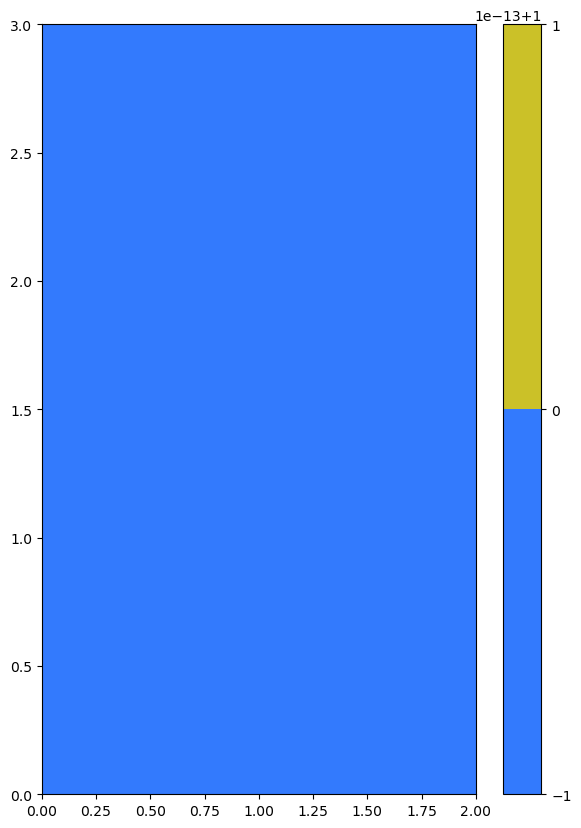

In [32]:
sol = [initial_solution]

t = 0

save_step(sol[-1], 0)

In [33]:
top_mass = top_mass_gen()
bottom_mass_gen = bottom_mass_gen()

In [34]:
bottom_stifness = bottom_stifness_gen()

In [35]:
M_gamma = boundary_field.assemble_mass_matrix(boundary_grid)

In [36]:
bot_lagrange = M_gamma @ bottom_isolate_boundary_dof
top_lagrange = M_gamma @ top_isolate_boundary_dof

Time 0.02083
Iteration #0001, error L2 relative psi:    0.146961634
Iteration #0002, error L2 relative psi:    0.058332147
Iteration #0003, error L2 relative psi:    0.019510823
Iteration #0004, error L2 relative psi:    0.003507351
Iteration #0005, error L2 relative psi:    0.000892677
Iteration #0006, error L2 relative psi:    0.000272585
Iteration #0007, error L2 relative psi:    0.000042863
Iteration #0008, error L2 relative psi:    0.000016963
Iteration #0009, error L2 relative psi:    0.000002608


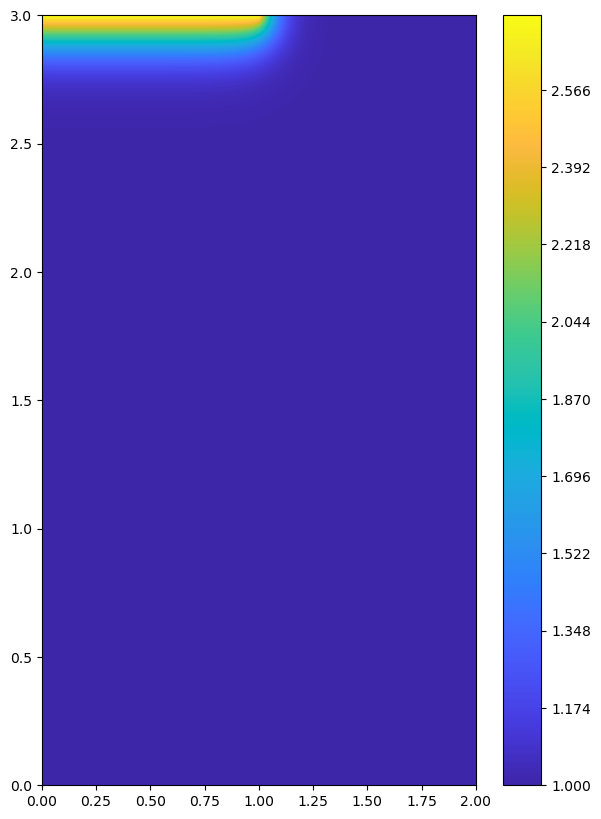


Time 0.04167
Iteration #0001, error L2 relative psi:    0.240834587
Iteration #0002, error L2 relative psi:    0.083895211
Iteration #0003, error L2 relative psi:    0.029133968
Iteration #0004, error L2 relative psi:    0.007936973
Iteration #0005, error L2 relative psi:    0.002821858
Iteration #0006, error L2 relative psi:    0.001067261
Iteration #0007, error L2 relative psi:    0.000269578
Iteration #0008, error L2 relative psi:    0.000098940
Iteration #0009, error L2 relative psi:    0.000031126
Iteration #0010, error L2 relative psi:    0.000008895


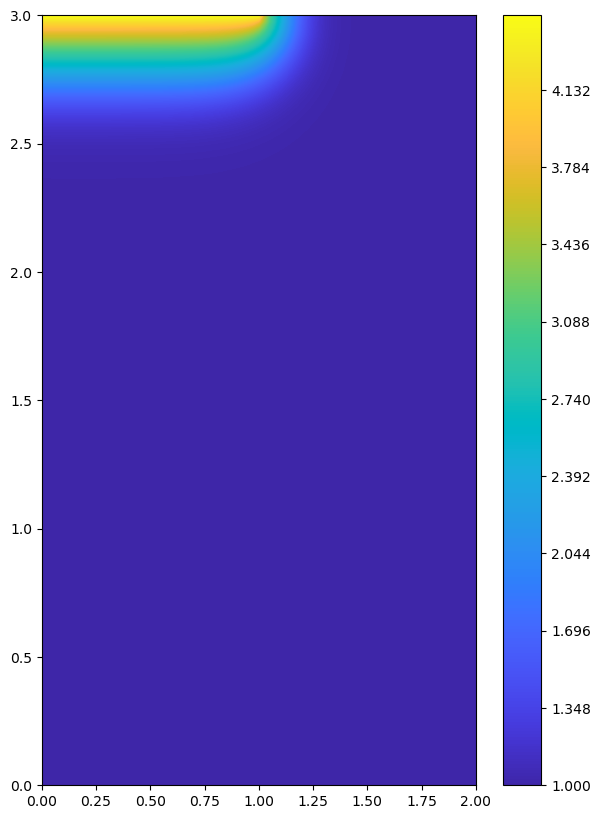


Time 0.0625
Iteration #0001, error L2 relative psi:    0.263544930
Iteration #0002, error L2 relative psi:    0.070187770
Iteration #0003, error L2 relative psi:    0.026022453
Iteration #0004, error L2 relative psi:    0.008460669
Iteration #0005, error L2 relative psi:    0.002323916
Iteration #0006, error L2 relative psi:    0.000656351
Iteration #0007, error L2 relative psi:    0.000287975
Iteration #0008, error L2 relative psi:    0.000137773
Iteration #0009, error L2 relative psi:    0.000060502
Iteration #0010, error L2 relative psi:    0.000024392
Iteration #0011, error L2 relative psi:    0.000009726


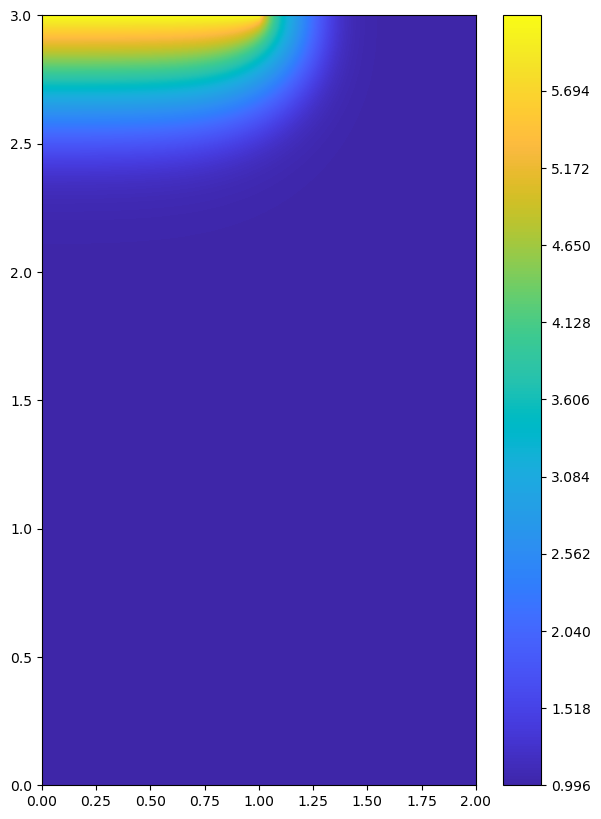


Time 0.08333
Iteration #0001, error L2 relative psi:    0.094414490
Iteration #0002, error L2 relative psi:    0.034453922
Iteration #0003, error L2 relative psi:    0.015422343
Iteration #0004, error L2 relative psi:    0.007580429
Iteration #0005, error L2 relative psi:    0.004112159
Iteration #0006, error L2 relative psi:    0.002378113
Iteration #0007, error L2 relative psi:    0.001403873
Iteration #0008, error L2 relative psi:    0.000830505
Iteration #0009, error L2 relative psi:    0.000491074
Iteration #0010, error L2 relative psi:    0.000290385
Iteration #0011, error L2 relative psi:    0.000171773
Iteration #0012, error L2 relative psi:    0.000101642
Iteration #0013, error L2 relative psi:    0.000060158
Iteration #0014, error L2 relative psi:    0.000035610
Iteration #0015, error L2 relative psi:    0.000021080
Iteration #0016, error L2 relative psi:    0.000012479
Iteration #0017, error L2 relative psi:    0.000007388


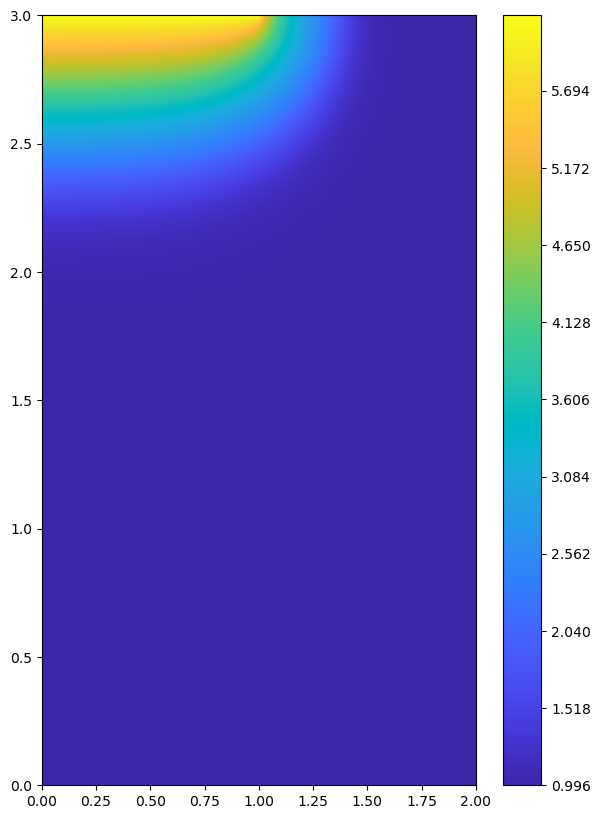


Time 0.10417
Iteration #0001, error L2 relative psi:    0.062298029
Iteration #0002, error L2 relative psi:    0.022500241
Iteration #0003, error L2 relative psi:    0.011723220
Iteration #0004, error L2 relative psi:    0.007138521
Iteration #0005, error L2 relative psi:    0.004692367
Iteration #0006, error L2 relative psi:    0.003180341
Iteration #0007, error L2 relative psi:    0.002180879
Iteration #0008, error L2 relative psi:    0.001503433
Iteration #0009, error L2 relative psi:    0.001039398
Iteration #0010, error L2 relative psi:    0.000719771
Iteration #0011, error L2 relative psi:    0.000498926
Iteration #0012, error L2 relative psi:    0.000346065
Iteration #0013, error L2 relative psi:    0.000240139
Iteration #0014, error L2 relative psi:    0.000166684
Iteration #0015, error L2 relative psi:    0.000115720
Iteration #0016, error L2 relative psi:    0.000080349
Iteration #0017, error L2 relative psi:    0.000055795
Iteration #0018, error L2 relative psi:    0.000038

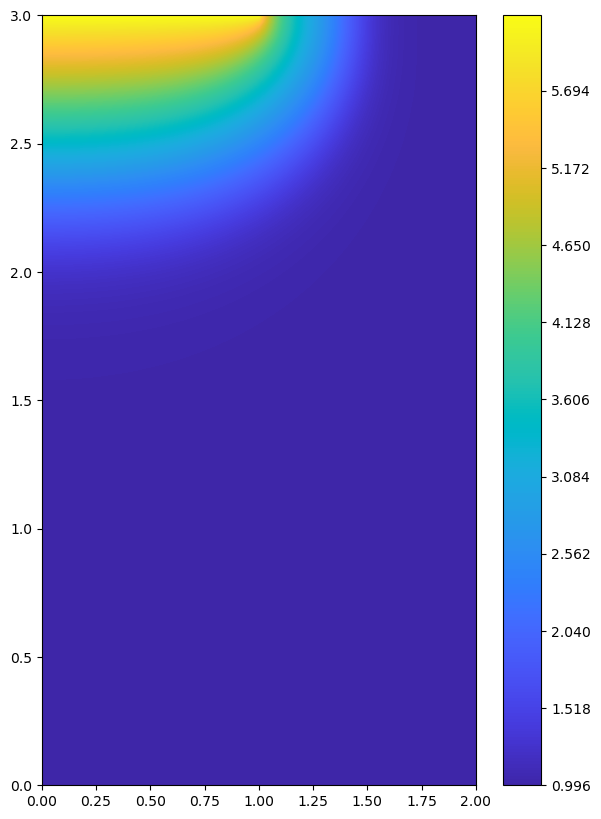


Time 0.125
Iteration #0001, error L2 relative psi:    0.046307776
Iteration #0002, error L2 relative psi:    0.016957300
Iteration #0003, error L2 relative psi:    0.009738433
Iteration #0004, error L2 relative psi:    0.006576487
Iteration #0005, error L2 relative psi:    0.004750281
Iteration #0006, error L2 relative psi:    0.003525556
Iteration #0007, error L2 relative psi:    0.002649571
Iteration #0008, error L2 relative psi:    0.002004548
Iteration #0009, error L2 relative psi:    0.001522461
Iteration #0010, error L2 relative psi:    0.001159090
Iteration #0011, error L2 relative psi:    0.000883817
Iteration #0012, error L2 relative psi:    0.000674634
Iteration #0013, error L2 relative psi:    0.000515346
Iteration #0014, error L2 relative psi:    0.000393880
Iteration #0015, error L2 relative psi:    0.000301153
Iteration #0016, error L2 relative psi:    0.000230314
Iteration #0017, error L2 relative psi:    0.000176171
Iteration #0018, error L2 relative psi:    0.00013477

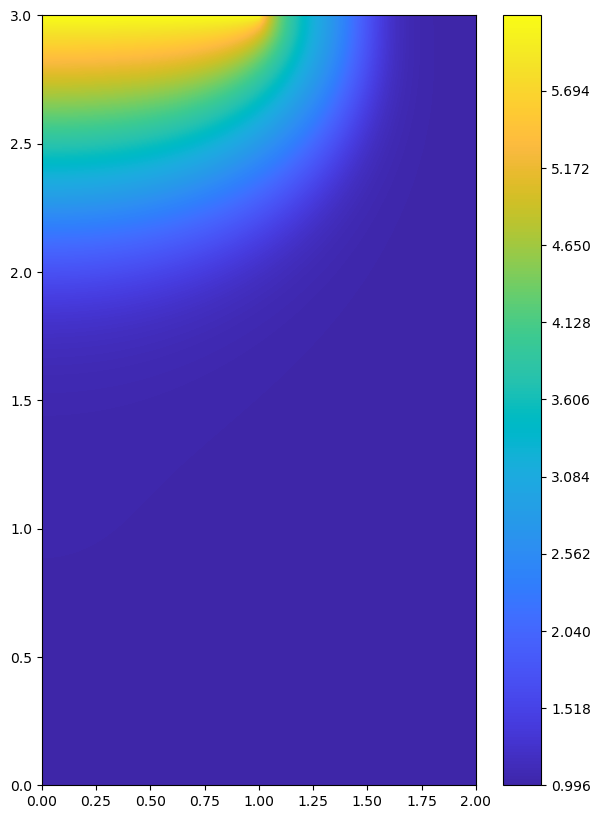


Time 0.14583
Iteration #0001, error L2 relative psi:    0.036373152
Iteration #0002, error L2 relative psi:    0.014072017
Iteration #0003, error L2 relative psi:    0.008827545
Iteration #0004, error L2 relative psi:    0.006409677
Iteration #0005, error L2 relative psi:    0.004949942
Iteration #0006, error L2 relative psi:    0.003929086
Iteration #0007, error L2 relative psi:    0.003162208
Iteration #0008, error L2 relative psi:    0.002564520
Iteration #0009, error L2 relative psi:    0.002089460
Iteration #0010, error L2 relative psi:    0.001707593
Iteration #0011, error L2 relative psi:    0.001398520
Iteration #0012, error L2 relative psi:    0.001147206
Iteration #0013, error L2 relative psi:    0.000942195
Iteration #0014, error L2 relative psi:    0.000774553
Iteration #0015, error L2 relative psi:    0.000637212
Iteration #0016, error L2 relative psi:    0.000524531
Iteration #0017, error L2 relative psi:    0.000431971
Iteration #0018, error L2 relative psi:    0.000355

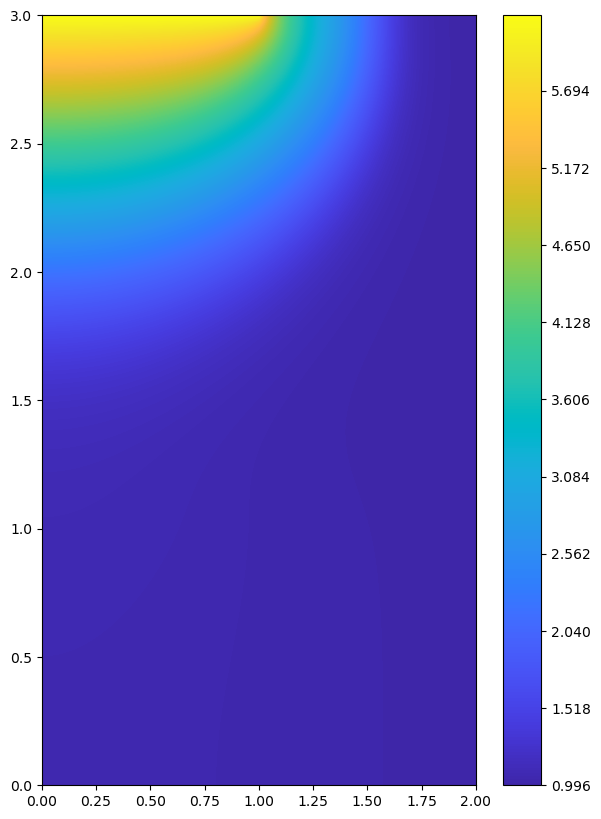


Time 0.16667
Iteration #0001, error L2 relative psi:    0.029441257
Iteration #0002, error L2 relative psi:    0.012709748
Iteration #0003, error L2 relative psi:    0.009325441
Iteration #0004, error L2 relative psi:    0.007738478
Iteration #0005, error L2 relative psi:    0.006732581
Iteration #0006, error L2 relative psi:    0.005981346
Iteration #0007, error L2 relative psi:    0.005372978
Iteration #0008, error L2 relative psi:    0.004858262
Iteration #0009, error L2 relative psi:    0.004409498
Iteration #0010, error L2 relative psi:    0.004012101
Iteration #0011, error L2 relative psi:    0.003658173
Iteration #0012, error L2 relative psi:    0.003341694
Iteration #0013, error L2 relative psi:    0.003057579
Iteration #0014, error L2 relative psi:    0.002801535
Iteration #0015, error L2 relative psi:    0.002569996
Iteration #0016, error L2 relative psi:    0.002359970
Iteration #0017, error L2 relative psi:    0.002168967
Iteration #0018, error L2 relative psi:    0.001994

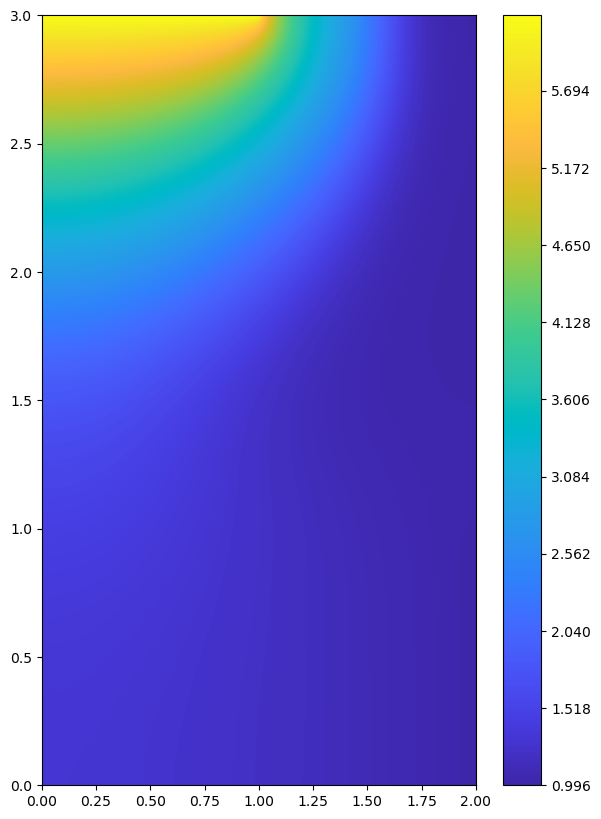


Time 0.1875
Iteration #0001, error L2 relative psi:    0.023788215
Iteration #0002, error L2 relative psi:    0.010896591
Iteration #0003, error L2 relative psi:    0.009030349
Iteration #0004, error L2 relative psi:    0.008186097
Iteration #0005, error L2 relative psi:    0.007587596
Iteration #0006, error L2 relative psi:    0.007073857
Iteration #0007, error L2 relative psi:    0.006606610
Iteration #0008, error L2 relative psi:    0.006174688
Iteration #0009, error L2 relative psi:    0.005773866
Iteration #0010, error L2 relative psi:    0.005401620
Iteration #0011, error L2 relative psi:    0.005055861
Iteration #0012, error L2 relative psi:    0.004734612
Iteration #0013, error L2 relative psi:    0.004435993
Iteration #0014, error L2 relative psi:    0.004158239
Iteration #0015, error L2 relative psi:    0.003899698
Iteration #0016, error L2 relative psi:    0.003658838
Iteration #0017, error L2 relative psi:    0.003434278
Iteration #0018, error L2 relative psi:    0.0032247

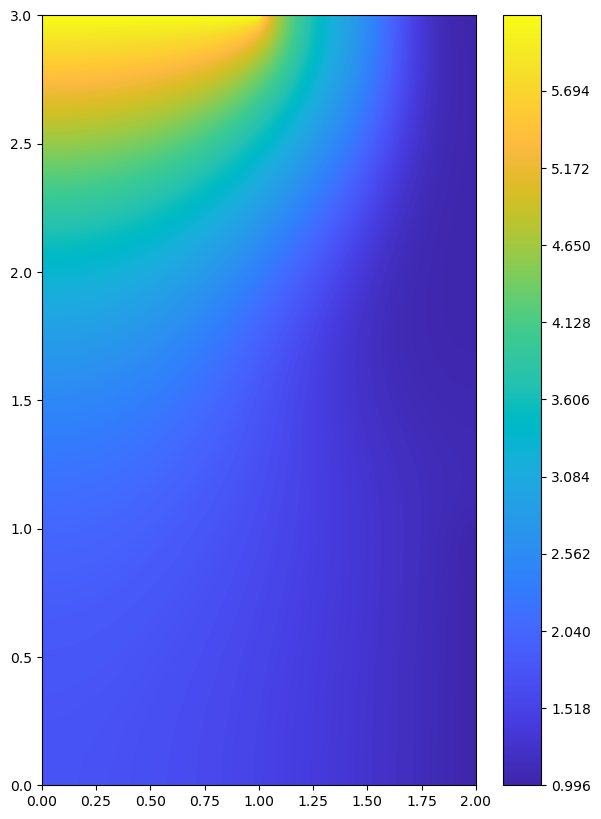


Time 0.20833
Iteration #0001, error L2 relative psi:    0.019803988
Iteration #0002, error L2 relative psi:    0.007546902
Iteration #0003, error L2 relative psi:    0.005424793
Iteration #0004, error L2 relative psi:    0.004446502
Iteration #0005, error L2 relative psi:    0.003859964
Iteration #0006, error L2 relative psi:    0.003450343
Iteration #0007, error L2 relative psi:    0.003139797
Iteration #0008, error L2 relative psi:    0.002891392
Iteration #0009, error L2 relative psi:    0.002684832
Iteration #0010, error L2 relative psi:    0.002507765
Iteration #0011, error L2 relative psi:    0.002352262
Iteration #0012, error L2 relative psi:    0.002213061
Iteration #0013, error L2 relative psi:    0.002086605
Iteration #0014, error L2 relative psi:    0.001970435
Iteration #0015, error L2 relative psi:    0.001862830
Iteration #0016, error L2 relative psi:    0.001762551
Iteration #0017, error L2 relative psi:    0.001668691
Iteration #0018, error L2 relative psi:    0.001580

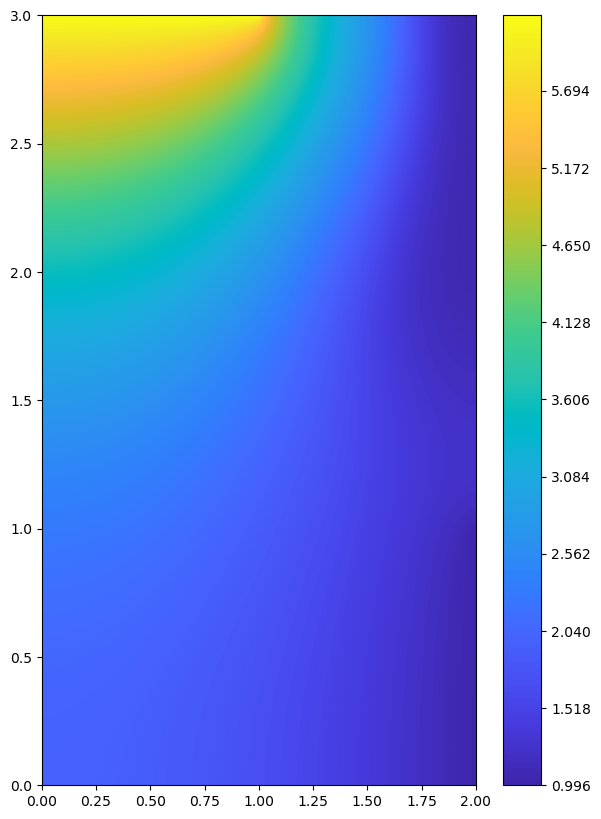


Time 0.22917
Iteration #0001, error L2 relative psi:    0.017675830
Iteration #0002, error L2 relative psi:    0.005834940
Iteration #0003, error L2 relative psi:    0.003943474
Iteration #0004, error L2 relative psi:    0.003097048
Iteration #0005, error L2 relative psi:    0.002609377
Iteration #0006, error L2 relative psi:    0.002280826
Iteration #0007, error L2 relative psi:    0.002040163
Iteration #0008, error L2 relative psi:    0.001854275
Iteration #0009, error L2 relative psi:    0.001705251
Iteration #0010, error L2 relative psi:    0.001582208
Iteration #0011, error L2 relative psi:    0.001478016
Iteration #0012, error L2 relative psi:    0.001387808
Iteration #0013, error L2 relative psi:    0.001308182
Iteration #0014, error L2 relative psi:    0.001236724
Iteration #0015, error L2 relative psi:    0.001171711
Iteration #0016, error L2 relative psi:    0.001111905
Iteration #0017, error L2 relative psi:    0.001056407
Iteration #0018, error L2 relative psi:    0.001004

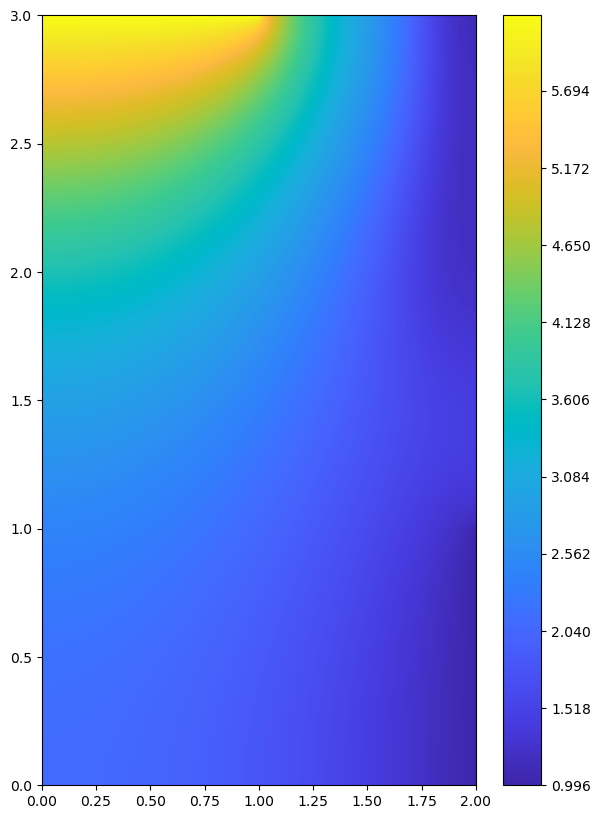


Time 0.25
Iteration #0001, error L2 relative psi:    0.016765009
Iteration #0002, error L2 relative psi:    0.005297925
Iteration #0003, error L2 relative psi:    0.003562755
Iteration #0004, error L2 relative psi:    0.002791552
Iteration #0005, error L2 relative psi:    0.002345064
Iteration #0006, error L2 relative psi:    0.002043931
Iteration #0007, error L2 relative psi:    0.001822797
Iteration #0008, error L2 relative psi:    0.001651607
Iteration #0009, error L2 relative psi:    0.001514276
Iteration #0010, error L2 relative psi:    0.001401150
Iteration #0011, error L2 relative psi:    0.001305930
Iteration #0012, error L2 relative psi:    0.001224262
Iteration #0013, error L2 relative psi:    0.001153026
Iteration #0014, error L2 relative psi:    0.001089933
Iteration #0015, error L2 relative psi:    0.001033285
Iteration #0016, error L2 relative psi:    0.000981812
Iteration #0017, error L2 relative psi:    0.000934559
Iteration #0018, error L2 relative psi:    0.000890803

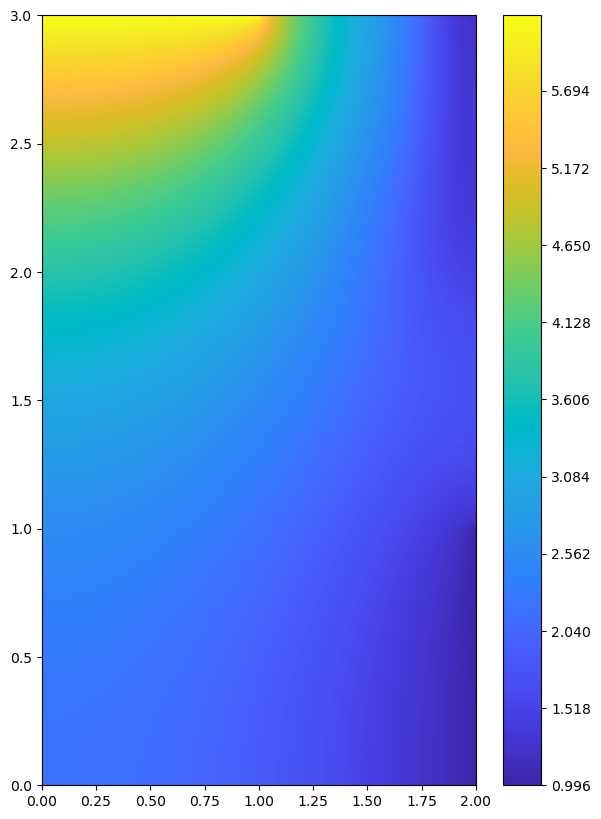


Time 0.27083
Iteration #0001, error L2 relative psi:    0.016269745
Iteration #0002, error L2 relative psi:    0.005571720
Iteration #0003, error L2 relative psi:    0.003827653
Iteration #0004, error L2 relative psi:    0.003040152
Iteration #0005, error L2 relative psi:    0.002571093
Iteration #0006, error L2 relative psi:    0.002250069
Iteration #0007, error L2 relative psi:    0.002012325
Iteration #0008, error L2 relative psi:    0.001827213
Iteration #0009, error L2 relative psi:    0.001678017
Iteration #0010, error L2 relative psi:    0.001554661
Iteration #0011, error L2 relative psi:    0.001450602
Iteration #0012, error L2 relative psi:    0.001361336
Iteration #0013, error L2 relative psi:    0.001283629
Iteration #0014, error L2 relative psi:    0.001215085
Iteration #0015, error L2 relative psi:    0.001153890
Iteration #0016, error L2 relative psi:    0.001098653
Iteration #0017, error L2 relative psi:    0.001048293
Iteration #0018, error L2 relative psi:    0.001001

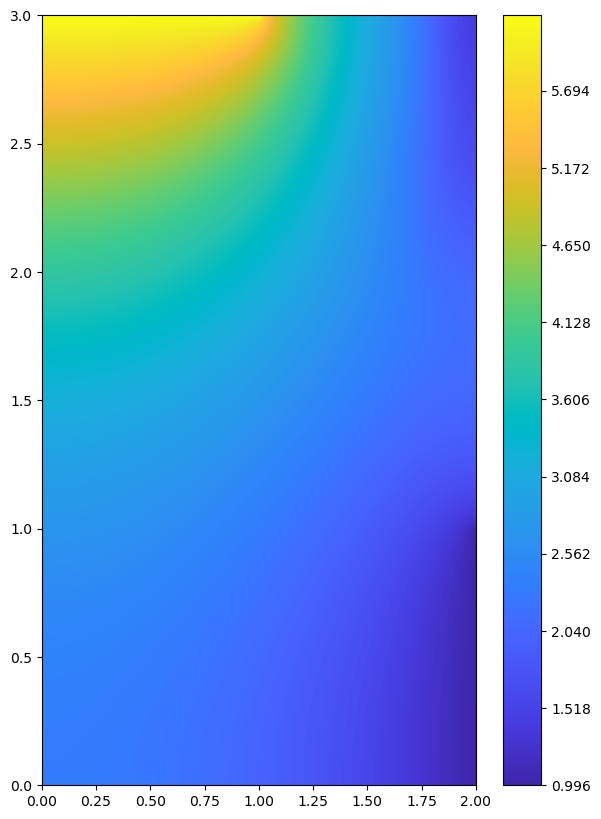


Time 0.29167
Iteration #0001, error L2 relative psi:    0.015318336
Iteration #0002, error L2 relative psi:    0.006193886
Iteration #0003, error L2 relative psi:    0.004403952
Iteration #0004, error L2 relative psi:    0.003559136
Iteration #0005, error L2 relative psi:    0.003035032
Iteration #0006, error L2 relative psi:    0.002666725
Iteration #0007, error L2 relative psi:    0.002389471
Iteration #0008, error L2 relative psi:    0.002171452
Iteration #0009, error L2 relative psi:    0.001994764
Iteration #0010, error L2 relative psi:    0.001848290
Iteration #0011, error L2 relative psi:    0.001724695
Iteration #0012, error L2 relative psi:    0.001618856
Iteration #0013, error L2 relative psi:    0.001527043
Iteration #0014, error L2 relative psi:    0.001446471
Iteration #0015, error L2 relative psi:    0.001375004
Iteration #0016, error L2 relative psi:    0.001310979
Iteration #0017, error L2 relative psi:    0.001253079
Iteration #0018, error L2 relative psi:    0.001200

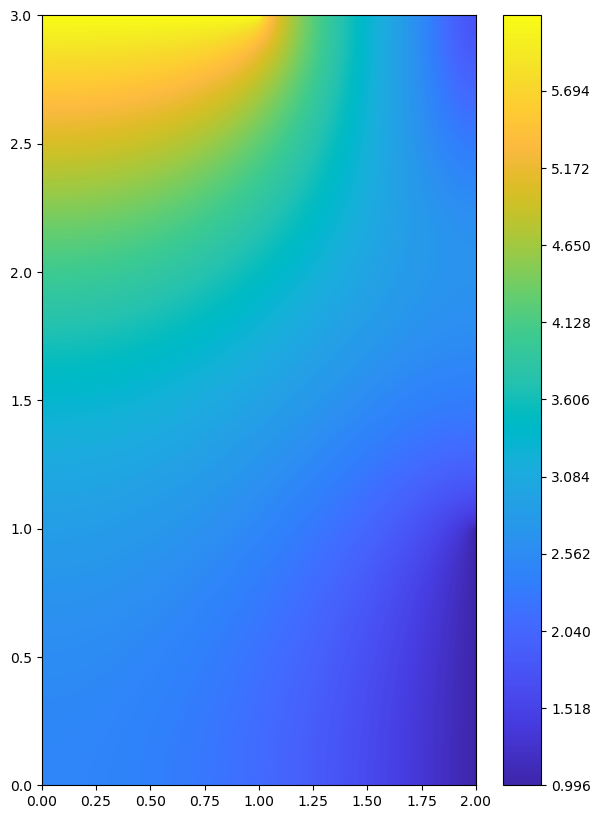


Time 0.3125
Iteration #0001, error L2 relative psi:    0.013550326
Iteration #0002, error L2 relative psi:    0.006885526
Iteration #0003, error L2 relative psi:    0.005149981
Iteration #0004, error L2 relative psi:    0.004291360
Iteration #0005, error L2 relative psi:    0.003747459
Iteration #0006, error L2 relative psi:    0.003357330
Iteration #0007, error L2 relative psi:    0.003056932
Iteration #0008, error L2 relative psi:    0.002815171
Iteration #0009, error L2 relative psi:    0.002614778
Iteration #0010, error L2 relative psi:    0.002445222
Iteration #0011, error L2 relative psi:    0.002299472
Iteration #0012, error L2 relative psi:    0.002172682
Iteration #0013, error L2 relative psi:    0.002061249
Iteration #0014, error L2 relative psi:    0.001962441
Iteration #0015, error L2 relative psi:    0.001874165
Iteration #0016, error L2 relative psi:    0.001794696
Iteration #0017, error L2 relative psi:    0.001722675
Iteration #0018, error L2 relative psi:    0.0016569

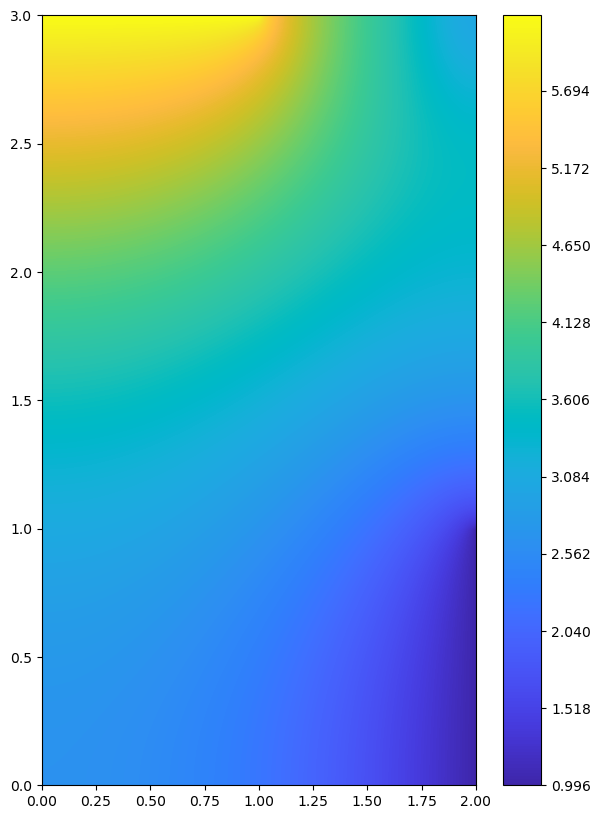


Time 0.33333
Iteration #0001, error L2 relative psi:    0.007796401
Iteration #0002, error L2 relative psi:    0.005670063
Iteration #0003, error L2 relative psi:    0.004606890
Iteration #0004, error L2 relative psi:    0.003953422
Iteration #0005, error L2 relative psi:    0.003497854
Iteration #0006, error L2 relative psi:    0.003153742
Iteration #0007, error L2 relative psi:    0.002879765
Iteration #0008, error L2 relative psi:    0.002653749
Iteration #0009, error L2 relative psi:    0.002462658
Iteration #0010, error L2 relative psi:    0.002298236
Iteration #0011, error L2 relative psi:    0.002154918
Iteration #0012, error L2 relative psi:    0.002028758
Iteration #0013, error L2 relative psi:    0.001916831
Iteration #0014, error L2 relative psi:    0.001816889
Iteration #0015, error L2 relative psi:    0.001727155
Iteration #0016, error L2 relative psi:    0.001646187
Iteration #0017, error L2 relative psi:    0.001572795
Iteration #0018, error L2 relative psi:    0.001505

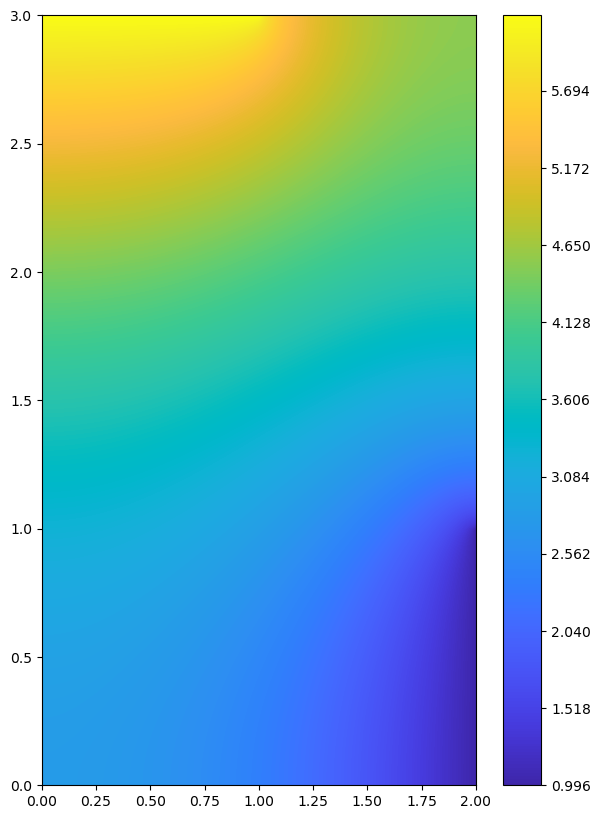


Time 0.35417
Iteration #0001, error L2 relative psi:    0.000009680


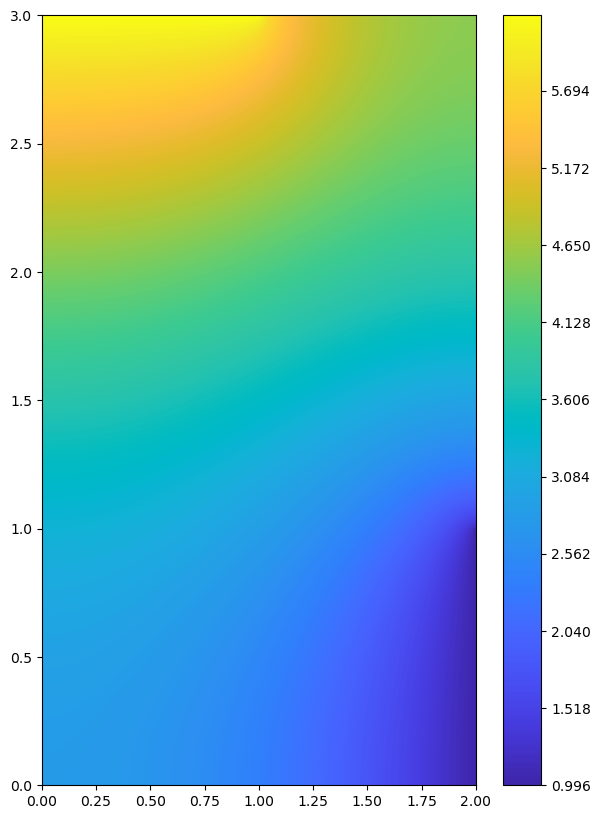


Time 0.375
Iteration #0001, error L2 relative psi:    0.000009432


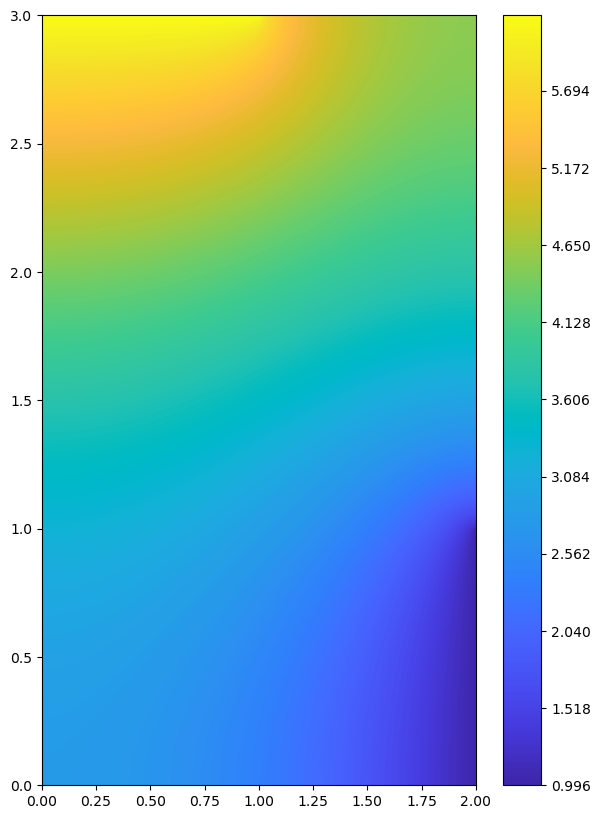


Time 0.39583
Iteration #0001, error L2 relative psi:    0.000009190


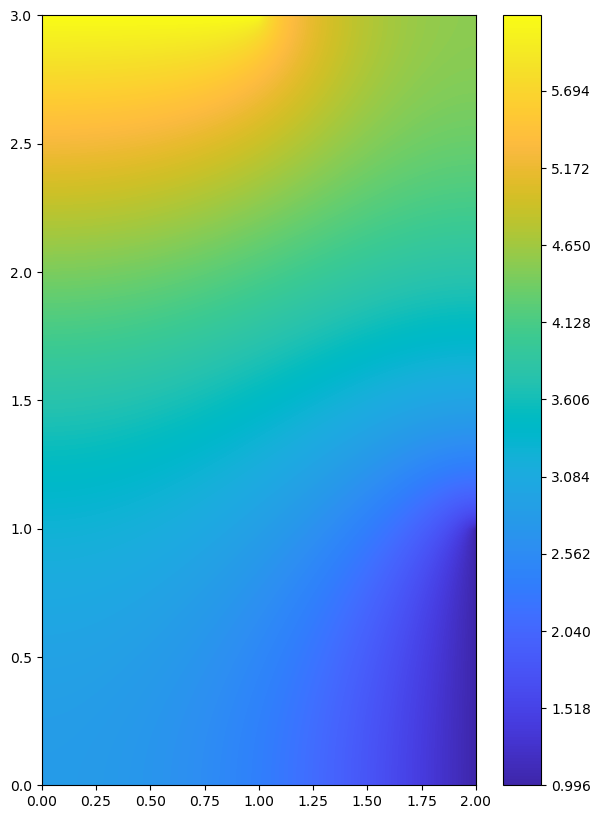


Time 0.41667
Iteration #0001, error L2 relative psi:    0.000008954


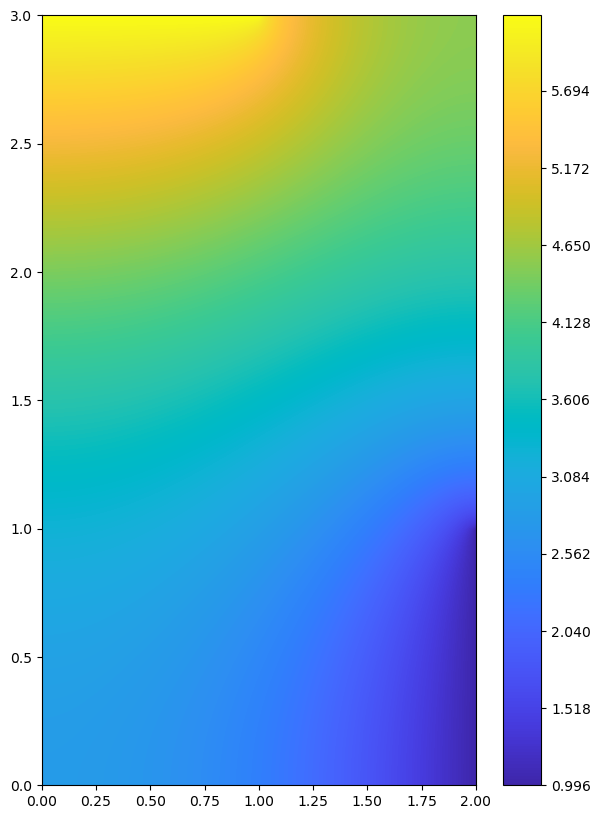


Time 0.4375
Iteration #0001, error L2 relative psi:    0.000008725


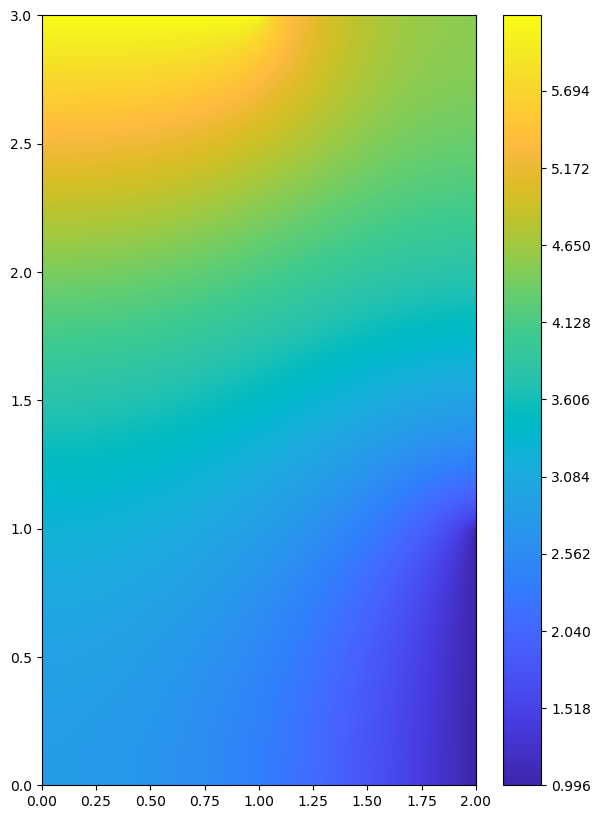


Time 0.45833
Iteration #0001, error L2 relative psi:    0.000008501


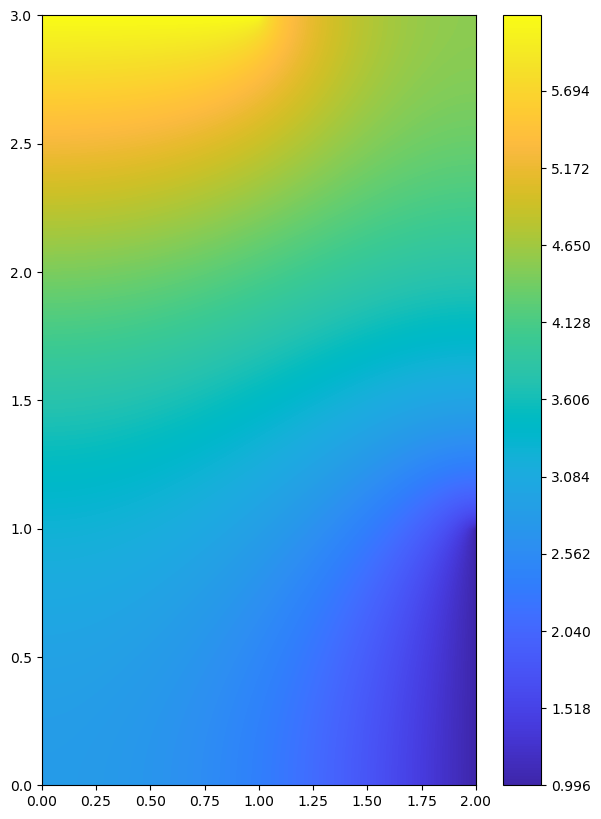


Time 0.47917
Iteration #0001, error L2 relative psi:    0.000008283


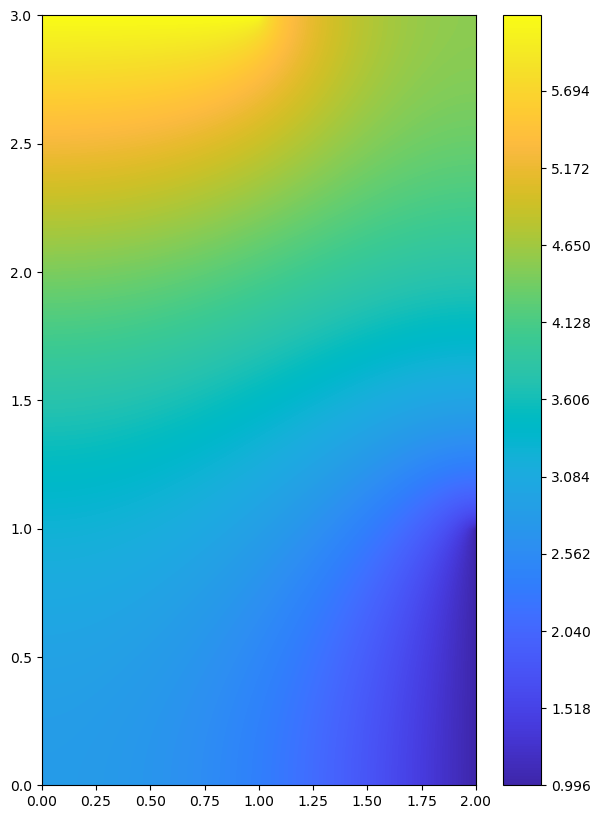


Time 0.5
Iteration #0001, error L2 relative psi:    0.000008070


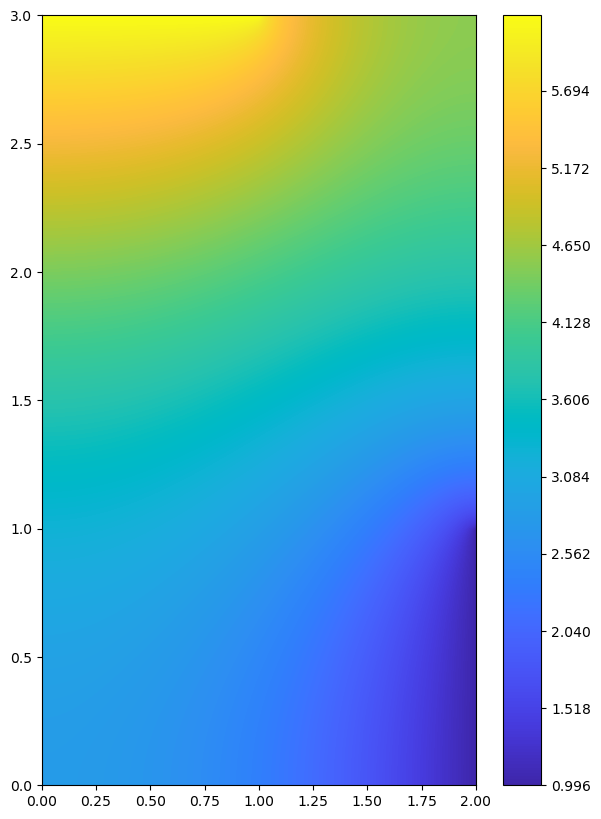


Time 0.52083
Iteration #0001, error L2 relative psi:    0.000007864


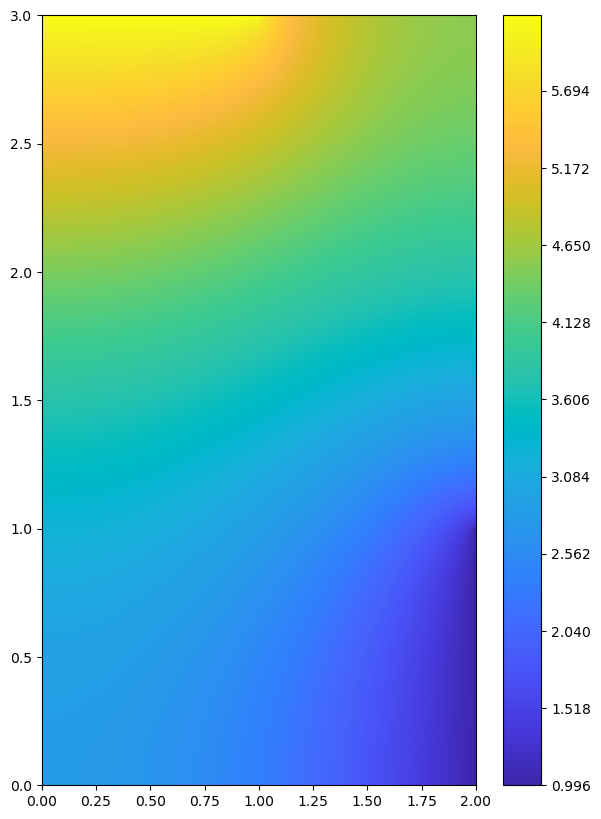


Time 0.54167
Iteration #0001, error L2 relative psi:    0.000007662


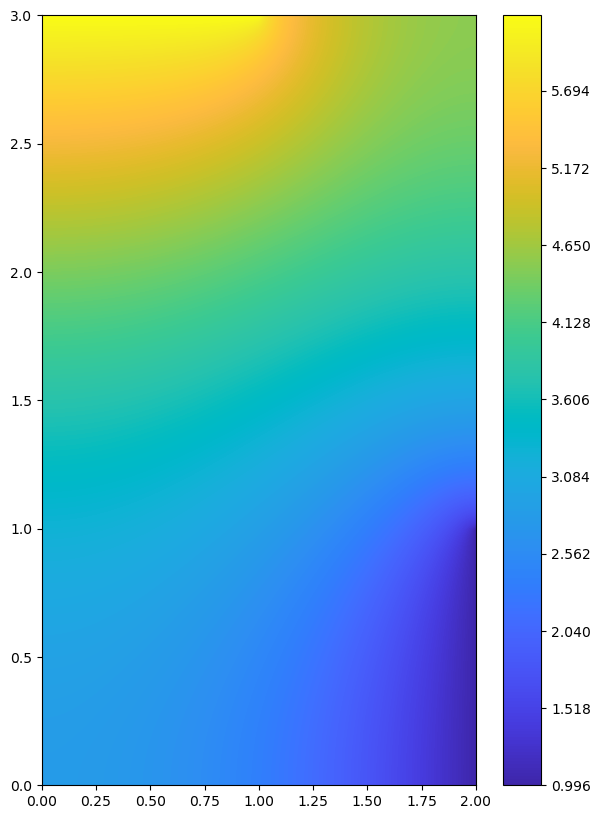


Time 0.5625
Iteration #0001, error L2 relative psi:    0.000007465


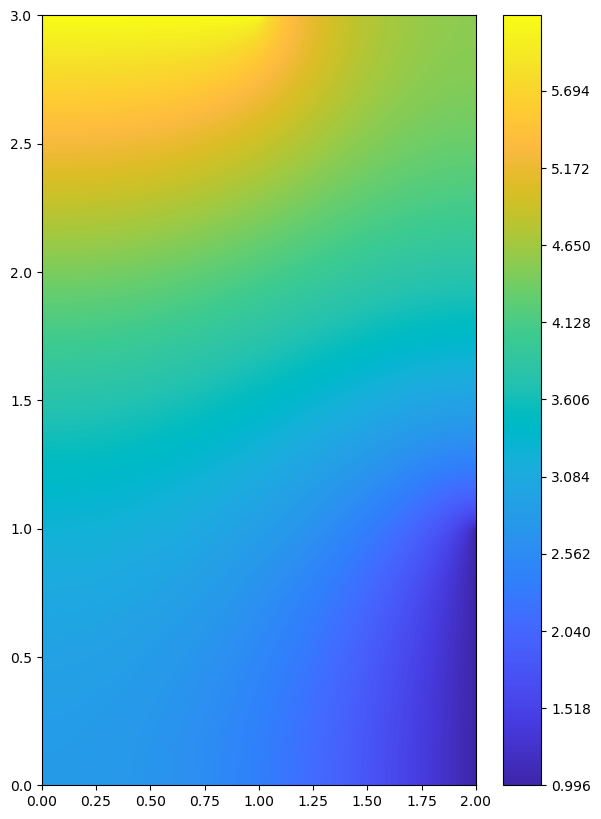

In [37]:
# Time Loop
for step in range(1, ceil(T/dt) + 1):
    current_time = step * dt
    print('Time ' + str(round(current_time, 5)))
    
    time_rhs = np.zeros_like(sol[-1])

    time_rhs[top_mask] += top_mass @ model_data.theta(sol[-1][top_mask], 1 + top_grid.nodes[1,:]) / dt

    prev = sol[-1]

    for k in range(K):
        rhs = time_rhs.copy()

        rhs[top_mask] += L * top_mass @ prev[top_mask] / dt
        rhs[top_mask] -= top_mass @ model_data.theta(prev[top_mask], 1 + top_grid.nodes[1,:]) / dt

        bottom_mat = bottom_stifness
        top_stifness = top_stifness_gen(prev[top_mask])

        top_mat = top_stifness + L / dt * top_mass

        spp = sps.bmat([[  bottom_mat,          None,  bot_lagrange.T],
                        [        None,       top_mat, -top_lagrange.T],
                        [bot_lagrange, -top_lagrange,            None]], format='csc')
        
        ls = pg.LinearSystem(spp, rhs)

        ls.flag_ess_bc(dirichlet_flag, dirichlet_value(current_time))

        current = ls.solve()

        # Check if we have reached convergence
        rel_err_psi  = np.sqrt( (current - prev)[h_mask].T @ (current - prev)[h_mask] )
        abs_err_prev = np.sqrt( prev[h_mask].T @ prev[h_mask] )

        # Log message with error and current iteration
        print('Iteration #' + format(k+1, '0' + str(ceil(log10(K)) + 1) + 'd') + ', error L2 relative psi: ' 
              + format(rel_err_psi / abs_err_prev, str(5 + ceil(log10(1 / abs_tol)) + 4) + '.' + str(ceil(log10(1 / abs_tol)) + 4) + 'f') )
        
        if rel_err_psi > abs_tol + rel_tol * abs_err_prev:
            prev = current.copy()
        else:
            break

    sol.append( current )

    save_step(sol[-1], step)
    print('')    